## Outline:

1. Identify a known dwarf galaxy (or some other type of concentration of sources - galaxy cluster?) to focus on. *I chose dwarf galaxy KKR 25.*
2. Select the relevant tracts, patches around KKR 25.
3. Show an image of the patch containing KKR 25.
4. Show an image of mosaiced patches, centered on KKR25.
5. Extract the photometry in the surrounding area.
6. Apply some quality cuts and star/galaxy separation.
7. Plot a CMD, with stars/galaxies highlighted separately. 
    
    -- explore sources that appear in the catalogs but do not have measured fluxes? (I suspect, but am not sure, that most of the stars in KKR 25 have NaN fluxes...)
8. Plot maps of the densities on the sky of sources around KKR25. Do we see the galaxy as an overdensity of point sources? extended sources? detected but un-measured sources?
9. Subtract the detected point sources from the image, and compare the original/residual images to see where the photometry starts to break down.

# Overdensities in source density maps
<br>Owner(s): **Jeff Carlin** ([@jeffcarlin](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@jeffcarlin)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **20XX-XX-XX**
<br>Verified Stack Release: **16.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Do this thing;
2. Do this other thing;
3. Understand this concept;
4. Produce your own etc etc.

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd ~/stackclub/StackClub/ && python setup.py -q develop --user && cd -

/home/jcarlin/stackclub/StackClub/Measurement/DensityMaps


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-w-2019-35
lsst_distrib          18.1.0-2-gb0efc0e+5 	current w_2019_35 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline
#%matplotlib ipympl

import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from astropy.table import hstack, vstack
from astropy.table import Table

In [5]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

import lsst.afw.display as afwDisplay

import lsst.pipe.base as pipeBase

In [6]:
params = {
   'axes.labelsize': 28,
   'font.size': 24,
   'legend.fontsize': 14,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 12,
   'xtick.minor.size': 6,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 12,
   'ytick.minor.size': 6,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
#   'text.usetex': True,
#   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [9, 8]
   }

plt.rcParams.update(params)

Tract IDs of HSC data can be found at: https://hsc-release.mtk.nao.ac.jp/doc/index.php/database/

Data discovery following: https://github.com/lsst-sqre/notebook-demo/blob/u/jcarlin/DM-15123/hsc_cosmos_comparison.ipynb

In [7]:
depth = 'DEEP' #'WIDE'
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

In [8]:
infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/%s/deepCoadd-results/HSC-I/*/*/calexp-*.fits'%(depth))
print(len(infiles))

1303


In [9]:
def getPatchCenter(skymap, tract, patch):
    # Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    patch = list(map(int, patch.split(',')))
    wcs = skymap.generateTract(tract).getWcs()
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox()
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

tract_array = []
patch_array = []

# Each line of "infiles" looks like this (infile[0]):
# '/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-I/17130/8,8/calexp-HSC-I-17130-8,8.fits'

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):
#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'DM-13666',
# 'DEEP',
# 'deepCoadd-results',
# 'HSC-I',
# '17130',
# '8,8',
# 'calexp-HSC-I-17130-8,8.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

print('Found %i patches'%(len(patch_array)))
    
skymap = butler.get('deepCoadd_skyMap')
    
ra_center_array = np.tile(0., len(patch_array))
dec_center_array = np.tile(0., len(patch_array))
for ii, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[ii], dec_center_array[ii] = getPatchCenter(skymap, tract, patch)
    
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array}
df_tract_patch = pd.DataFrame(data=data)

Found 1303 patches


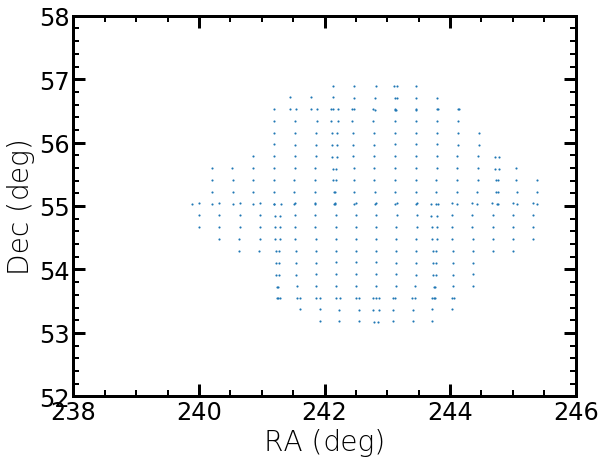

In [10]:
# Plot RA, Dec of patch centers:
plt.rcParams.update({'figure.figsize' : (9, 7)})

fig=plt.figure()
plt.scatter(df_tract_patch['ra_center'], df_tract_patch['dec_center'], marker='.', s=5)
# Centered on ELAIS-N1 field
plt.xlim(238., 246.)
plt.ylim(52., 58.)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

In [11]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_pos = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs') # KKR25
#cosmos_patch_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
hsc_patch_cen = SkyCoord(df_tract_patch['ra_center'].values*u.degree, df_tract_patch['dec_center'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_patches = hsc_patch_cen.separation(kkr25_pos)

# Pick patches within 'size_select' deg of KKR25:
size_select = 0.25 # in degrees
selection_patch = (sep_patches.degree < size_select) 
print('Number of patches selected: ',np.sum(selection_patch))


Number of patches selected:  8


In [12]:
kkr25_patch = (sep_patches == np.min(sep_patches))

In [13]:
tract_kkr25=df_tract_patch['tract'][kkr25_patch]
patch_kkr25=df_tract_patch['patch'][kkr25_patch]
print(tract,patch)
tract = tract_kkr25.values[0]
patch = patch_kkr25.values[0]

8524 7,3


In [14]:
df_tract_patch[selection_patch]

tract patch   ra_center  dec_center
3    17130   0,4  243.779176   54.290800
6    17130   1,5  243.463800   54.480400
15   17130   0,5  243.784999   54.477419
62   17130   2,4  243.139628   54.295875
73   17130   1,4  243.459432   54.293760
76   17130   2,5  243.142540   54.482530
733  17131   8,4  243.720664   54.290798
742  17131   8,5  243.714840   54.477417

In [15]:
df_selected = df_tract_patch[selection_patch]

In [16]:
import lsst.afw.coord as afwCoord
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

In [17]:
sub14 = butler.subset('deepCoadd_forced_src', filter='HSC-G', tract=17130, patch='1,4')
sub15 = butler.subset('deepCoadd_forced_src', filter='HSC-G', tract=17130, patch='1,5')

In [18]:
#sub.cache[0]

In [19]:
#butler.datasetExists('deepCoadd_forced_src', dataId=sub.cache[0])

In [20]:
# Get the first image:
#dataref = subset.cache[0]
dataref14 = sub14.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}
dataref15 = sub15.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}

## Source catalog:
my_src14 = butler.get('deepCoadd_forced_src', dataId=dataref14)
my_src15 = butler.get('deepCoadd_forced_src', dataId=dataref15)

# Calibrated exposure:
my_calexp14 = butler.get('deepCoadd_calexp', dataId=dataref14)
my_calexp15 = butler.get('deepCoadd_calexp', dataId=dataref15)

# Extract the WCS and the calib object:
my_wcs14 = my_calexp14.getWcs()
my_calib14 = my_calexp14.getPhotoCalib()
#my_calib14.setThrowOnNegativeFlux(False) # For magnitudes
my_wcs15 = my_calexp15.getWcs()
my_calib15 = my_calexp15.getPhotoCalib()
#my_calib15.setThrowOnNegativeFlux(False) # For magnitudes

## Finally, get the reference table for the coadd sources:
#my_src_ref = butler.get('deepCoadd_ref', dataId=dataref)

# To see the names of columns in this table, use:
# my_src_ref.schema.getNames()

In [21]:
# Full patch image
image14 = butler.get('deepCoadd_calexp', immediate=True, dataId=dataref14)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_14 = image14.getXY0() 
# Full patch image
image15 = butler.get('deepCoadd_calexp', immediate=True, dataId=dataref15)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_15 = image15.getXY0() 

Text(0, 0.5, 'Y (pix)')

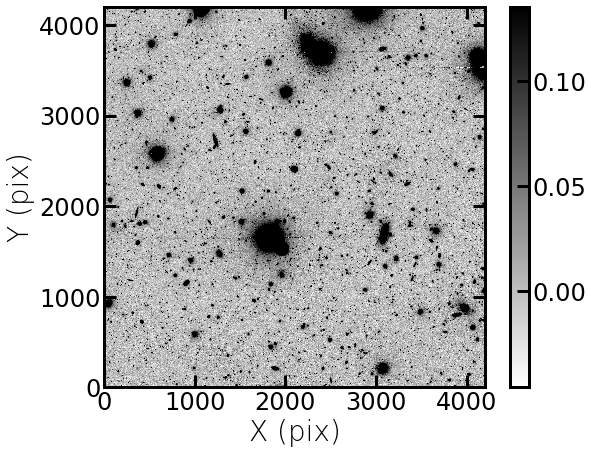

In [22]:
vmin, vmax = zscale.get_limits(image14.image.array)
#vmin, vmax = zscale.get_limits(image15.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = image14.getDimensions()
#imsize = image15.getDimensions()
#plt.rcParams.update({'figure.figsize' : (16, 12)})
plt.imshow(image14.image.array, vmin=vmin, vmax=vmax, cmap='binary')
#plt.imshow(image15.image.array, vmin=vmin, vmax=vmax, cmap='binary')
# Set the plot range to the dimensions:
plt.xlim(0,imsize[0])
plt.ylim(0,imsize[1])
plt.colorbar()
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

### Create an image (from multiple patches) centered on KKR 25:
(borrowing heavily from `ip_diffim`)

In [23]:
def arcmin2pix(narcmin):
    arcsecPerPix = 0.168  # HSC pixels are 0.168"/pixel
    arcminPerPix = arcsecPerPix / 60.0
    npix = narcmin/arcminPerPix
    return int(np.rint(npix))    

In [24]:
def cutoutImage(raDec, size_arcmin, filter):
    '''
    Function to extract an image cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, tract=tract, patch=patch, filter=filter)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, tract=tract, patch=patch, filter=filter)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
#    cutoutSize = afwGeom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position

#    print('xy: ',xy,' cutoutSize: ',cutoutSize)

# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)

# compute coadd bbox
    coaddWcs = tractInfo.getWcs()
    coaddBBox = geom.Box2D()
    for skyPos in skyCorners:
        coaddBBox.include(coaddWcs.skyToPixel(skyPos))
    coaddBBox = geom.Box2I(coaddBBox)

# assemble coadd exposure from subregions of patches
    coaddExposure = afwImage.ExposureF(coaddBBox, coaddWcs)
    coaddExposure.maskedImage.set(np.nan, afwImage.Mask.getPlaneBitMask("NO_DATA"), np.nan)
    nPatchesFound = 0
    coaddFilter = None
    for patchInfo in patchList:
        patchSubBBox = patchInfo.getOuterBBox()
        patchSubBBox.clip(coaddBBox)
        patchArgDict = dict(
                            datasetType="deepCoadd_calexp_sub",
                            bbox=patchSubBBox,
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = filter,
                            )
        print("Reading patch %s" % patchArgDict)
        coaddPatch = butler.get(**patchArgDict)
        nPatchesFound += 1
        coaddExposure.maskedImage.assign(coaddPatch.maskedImage, coaddPatch.getBBox())
        if coaddFilter is None:
            coaddFilter = coaddPatch.getFilter()

    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    coaddExposure.setFilter(coaddFilter)
    return pipeBase.Struct(exposure=coaddExposure, sources=None)

In [25]:
def cutoutCatalog(raDec, size_arcmin, filter):
    '''
    Function to extract an catalog cutout.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, tract=tract, patch=patch, filter=filter)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, tract=tract, patch=patch, filter=filter)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = filter,
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
#        calib.setThrowOnNegativeFlux(False)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
#        psfmags = calib.instFluxToMagnitude(src.getPsfInstFlux())
#        modelmags = calib.instFluxToMagnitude(src.getModelInstFlux())
        
        # Use astropy 'hstack' to glom the mags onto the src catalog
        #src_all = src #.asAstropy()
        #src_all.extend(psfmags)
        #src_all['psfmag'] = psfmags
        #src_all['modelmag'] = modelmags
        #hstack([src.asAstropy(), Table(psfmags)])
        mags = Table()
        mags['psfmag'] = psfmags
        mags['modelmag'] = modelmags


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [26]:
#src14 = butler.get('deepCoadd_forced_src', immediate=True, dataId=dataref14)
#src_schema = src14.getSchema()

In [27]:
## Columns for model flux measurements
#for name in src14.schema.getOrderedNames():
#    if 'model' in name.lower():
#        print(name)

In [28]:
import lsst.geom as geom

size_arcmin = 3.0
# Create a SpherePoint object at the center of KKR 25:
raDec = geom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, geom.degrees)
#raDec = afwGeom.SpherePoint(kkr25_pos.ra.value, kkr25_pos.dec.value, afwGeom.degrees)
# Extract the cutout image:
imgCutout = cutoutImage(raDec, size_arcmin, 'HSC-I')

Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}


([], <a list of 0 Text yticklabel objects>)

<Figure size 648x504 with 0 Axes>

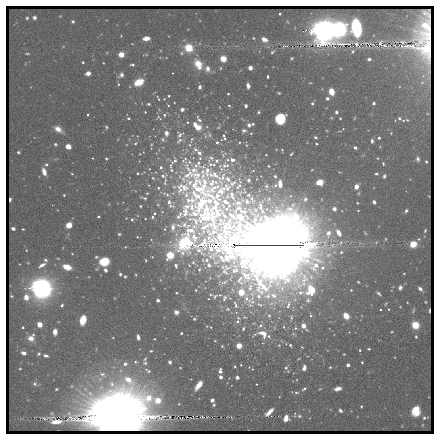

In [32]:
# Use lsst.afw.display with the matplotlib backend to display the image
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.image)
plt.xticks([])
plt.yticks([])

There's a beautiful, partially-resolved galaxy there. Unfortunately, there's a bright star right next to it. We'll have to see how that affects the measurements from the Stack.

What does the mask plane look like in this region?

([], <a list of 0 Text yticklabel objects>)

<Figure size 648x504 with 0 Axes>

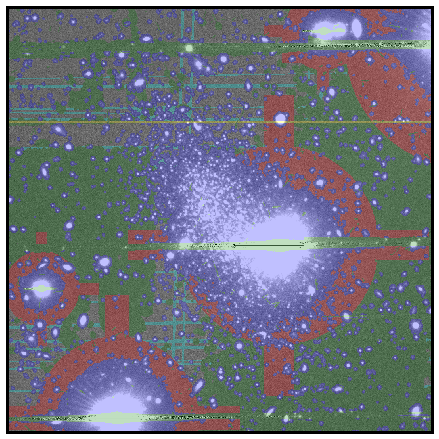

In [33]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(imgCutout.exposure.maskedImage)
plt.xticks([])
plt.yticks([])

In [38]:
#The MaskedImage is overplotting the values of the mask plane. Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in imgCutout.exposure.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))

red: BAD
None: BRIGHT_OBJECT
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


OK, so this is telling us that the stars in KKR 25 (because they are blue in the mask) are flagged as DETECTED. 

Extract concatenated source catalogs in the same footprint using the function we defined above:
(note: this returns catalog data for the entire patches that are part of the requested footprint, and not just within the radius specified)

In [39]:
cat_g, refcat_g, mags_g = cutoutCatalog(raDec, size_arcmin, 'HSC-G')
cat_r, refcat_r, mags_r = cutoutCatalog(raDec, size_arcmin, 'HSC-R')
cat_i, refcat_i, mags_i = cutoutCatalog(raDec, size_arcmin, 'HSC-I')

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

### Make some selections based on the data flags:

- detect_isPrimary
- require PSF fluxes to be measured (i.e., not 'NaN')
- sources that have been deblended (or were not blended)
- point sources (based on ClassificationExtendedness)

In [40]:
is_primary = (refcat_g['detect_isPrimary'] == True) & (refcat_r['detect_isPrimary'] == True) &\
             (refcat_i['detect_isPrimary'] == True) 
is_finite = (np.isfinite(cat_g.getPsfInstFlux())) & (np.isfinite(cat_r.getPsfInstFlux())) & (np.isfinite(cat_i.getPsfInstFlux()))
deblended = (cat_g['deblend_nChild'] == 0) & (cat_r['deblend_nChild'] == 0) & (cat_i['deblend_nChild'] == 0)
ptsource = (cat_g['base_ClassificationExtendedness_flag'] == False) & (cat_r['base_ClassificationExtendedness_flag'] == False) & (cat_i['base_ClassificationExtendedness_flag'] == False)

### Scatter plots of the source positions with various subsets selected:

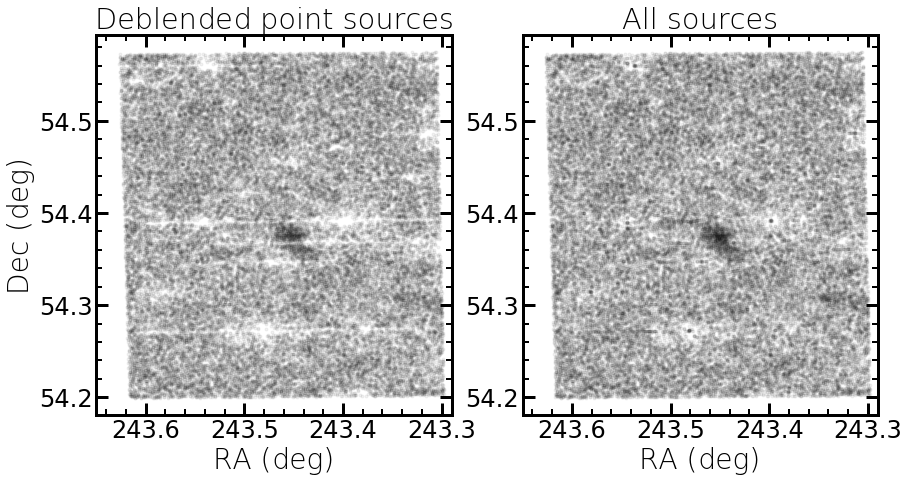

In [41]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.subplot(121)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource]),np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.title('Deblended point sources')

plt.subplot(122)
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary]),np.rad2deg(cat_g['coord_dec'][is_primary]),'k.',alpha=0.05)
plt.xlim(243.65,243.29)
plt.title('All sources')
plt.xlabel('RA (deg)')
#plt.ylabel('Dec (deg)')
plt.minorticks_on()

Good - we can see a concentration of sources in the center, which correspond to KKR 25. What if we plot this as a density map (i.e., a 2D histogram)? 

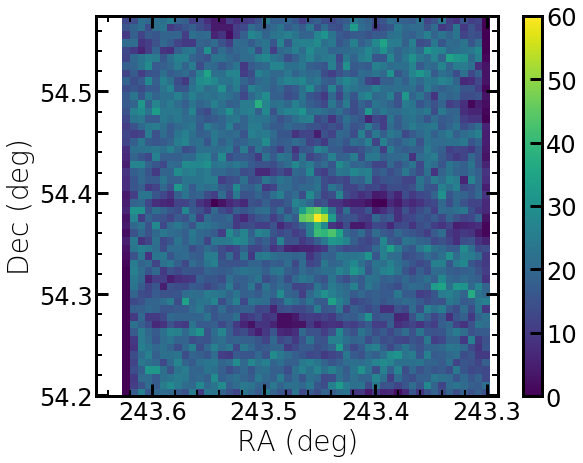

In [42]:
plt.rcParams.update({'figure.figsize' : (9, 7)})

plt.figure()
#plt.hist2d(np.rad2deg(cat_g['coord_ra'][is_primary & deblended]),np.rad2deg(cat_g['coord_dec'][is_primary & deblended]), bins=50)
plt.hist2d(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource]),np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource]), bins=50)
plt.colorbar()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.xlim(243.65,243.29)
plt.minorticks_on()
plt.show()

Cool! It looks like there's a galaxy there (and you can even see the "bite" taken out by the bright star that sits on top of it). Now - why don't we see it when we plot a CMD?

Let's plot the positions of objects classified as point sources, color-coded by their g-band PSF magnitude.

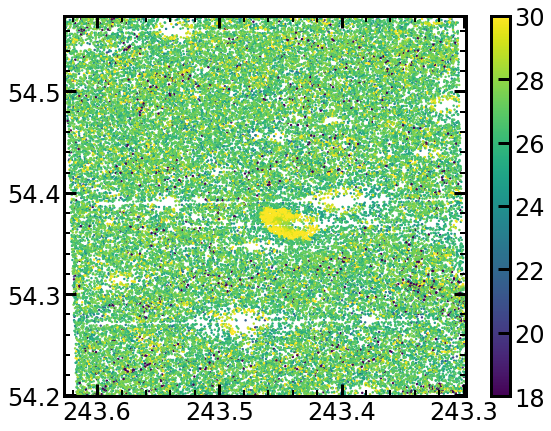

In [43]:
gmags0 = mags_g['psfmag']
gmags0[np.isnan(gmags0)] = 0.0
plt.scatter(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource]),\
            np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource]),\
            c=gmags0[is_primary & deblended & ptsource][:,0],s=2,vmax=30,vmin=18)
# NOTE: in the above line, gmags0 must be subscripted to select only the magnitude column. gmags0 contains both the
#       magnitudes and their errors, so to get mags only, use gmags0[:0] (for errors, use gmags0[:1])

#plt.scatter(np.rad2deg(cat_g['coord_ra']),np.rad2deg(cat_g['coord_dec']),c=gmags0,s=2,vmax=30,vmin=18)
plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])))
plt.ylim(np.min(np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource])),\
         np.max(np.rad2deg(cat_g['coord_dec'][is_primary & deblended & ptsource])))
plt.colorbar()
plt.minorticks_on()

All the sources in KKR25, while detected, seem to have magnitudes >= 30(!). Let try a histogram of magnitudes to see what's up:

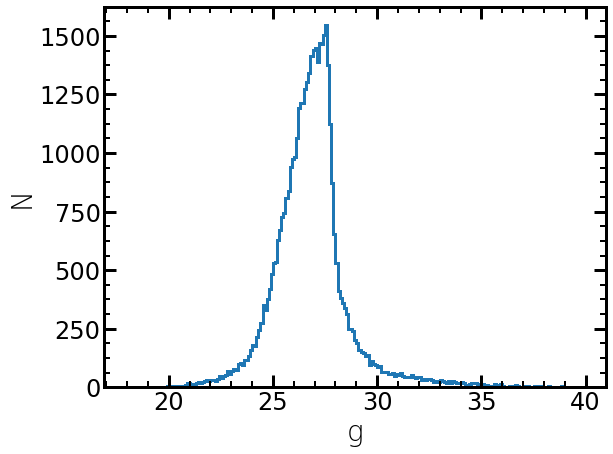

In [44]:
plt.hist(gmags0[is_primary & deblended & ptsource][:,0],bins=np.arange(18,40,0.1),histtype='step',linewidth=3)
plt.xlabel('g')
plt.ylabel('N')
plt.minorticks_on()

Plot magnitude vs. position to see if it's true that the g>28 sources are concentrated in KKR25:

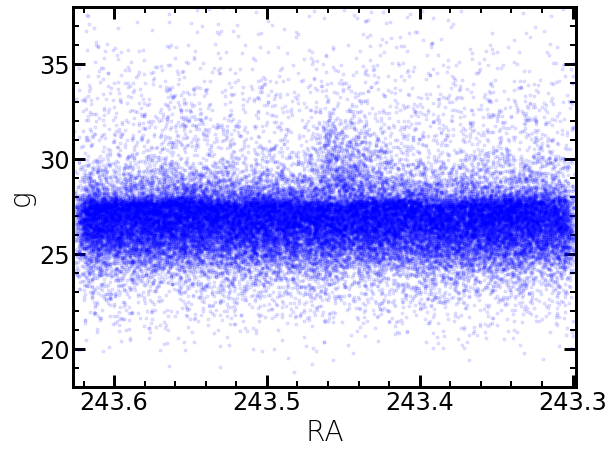

In [45]:
plt.plot(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource]),\
         gmags0[is_primary & deblended & ptsource][:,0],'b.',alpha=0.1)
plt.ylim(18,38)
plt.xlim(np.max(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])),\
         np.min(np.rad2deg(cat_g['coord_ra'][is_primary & deblended & ptsource])))
plt.xlabel('RA')
plt.ylabel('g')
plt.minorticks_on()

So, it looks like the Stack detects sources in the center, but when it measures them, it oversubtracts the background (as you might expect given the crowding and excess background in the galaxy).

## Plot a CMD of objects near KKR 25:

In [46]:
from astropy.io import ascii

iso = ascii.read('isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # 1.91e6 # in pc
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- look this up using the central coord?
dmod = 5.0*np.log10(dist) - 5.0 

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']
z_iso_ps1 = iso['zP1']

# Calculate colors needed to transform to HSC system
gr_iso_ps1 = g_iso_ps1 - r_iso_ps1
ri_iso_ps1 = r_iso_ps1 - i_iso_ps1
iz_iso_ps1 = i_iso_ps1 - z_iso_ps1

# PS1/HSC transformations from https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/#color-terms
# Resulting mags are in the HSC filter system:
g_iso_hsc = g_iso_ps1 #+ 0.00730066 + 0.06508481*gr_iso_ps1 - 0.01510570*(gr_iso_ps1**2)
r_iso_hsc = r_iso_ps1 #+ 0.00279757 + 0.02093734*ri_iso_ps1 - 0.01877566*(ri_iso_ps1**2)
i_iso_hsc = i_iso_ps1 #+ 0.00166891 - 0.13944659*iz_iso_ps1 - 0.03034094*(iz_iso_ps1**2)

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

g_iso = g_iso_hsc + dmod + A_g
r_iso = r_iso_hsc + dmod + A_r
i_iso = i_iso_hsc + dmod + A_i 

In [47]:
# Select a smaller region around KKR 25:
coord_g = SkyCoord(cat_g['coord_ra']*u.radian, cat_g['coord_dec']*u.radian, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = coord_g.separation(kkr25_pos)

# Select within some small radius:
sel_rad = 2.5
sel_cen = (sep_kkr25.arcmin < sel_rad)

In [48]:
# difference in mags (PSF - cmodel)
magdiff_i = mags_i['psfmag'][:,0]-mags_i['modelmag'][:,0]
starsel_i = (np.abs(magdiff_i) < 0.05)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


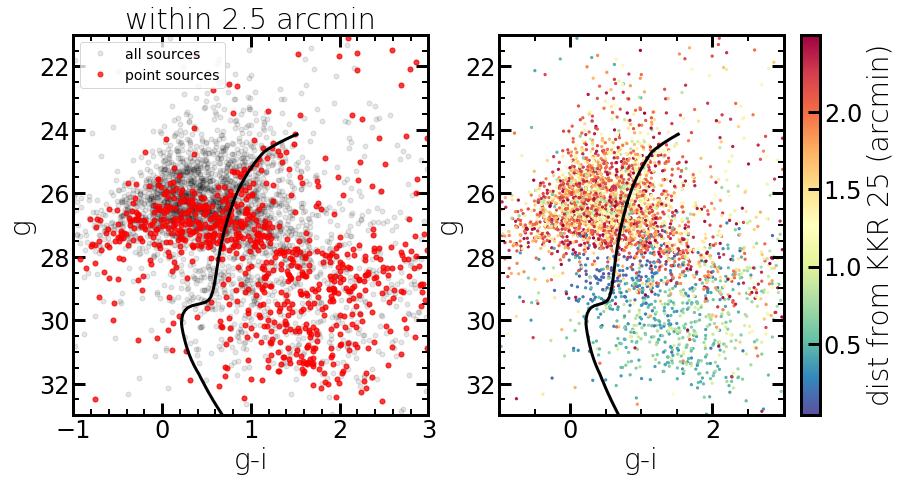

In [49]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.subplot(121)
plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources')
plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.scatter(mags_g['psfmag'][is_primary & sel_cen][:,0]-mags_i['psfmag'][is_primary & sel_cen][:,0],\
            mags_g['psfmag'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
#plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1)
#plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75)

#plt.plot(mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen]-mags_i['psfmag'][is_primary & deblended & ptsource & sel_cen], mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen], 'ro', ms=5, alpha=0.3)
#plt.plot(mags_g['psfmag'][is_primary & ~ptsource & sel_cen]-mags_i['psfmag'][is_primary & ~ptsource & sel_cen], mags_g['psfmag'][is_primary & ~ptsource & sel_cen], 'bo', ms=3, alpha=0.3)
#plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, df_hsc[notstar_selection_kkr25].psf_mag_g, 'bo', fillstyle='none', ms=2, alpha=0.3)
#plt.scatter(df_hsc[selection_kkr25].psf_mag_g-df_hsc[selection_kkr25].psf_mag_i, df_hsc[selection_kkr25].psf_mag_g,\
#            c=df_hsc[selection_kkr25].psf_mag_i-df_hsc[selection_kkr25].cm_mag_i, cmap='Spectral_r')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
#plt.show()

So, we can see that most of the stars nearest the center of KKR 25 (the blue/green points above) have "bogus" photometry (i.e., g > 28th mag).

## Try subtracting stars off the image(s)
(borrowing from J. Bosch's `intro-with-globular` notebook.

In [41]:
from lsst.afw.image import Exposure, Image, PARENT
from tqdm import tqdm_notebook

In [83]:
def subtractStars(data, cat, fluxes=None):
    """Subtract point sources from an image.
    
    Parameters
    ----------
    data : `lsst.afw.image.Exposure`
        Image from which point sources will be subtracted (not modified).
    cat : `lsst.afw.table.SourceCatalog`
        Catalog providing centroids and possibly fluxes.
    fluxes : `numpy.ndarray`, optional
        If not None, an array of the same length as ``cat`` containing fluxes
        to use.  If None, ``cat.getPsfFlux()` will be used instead.
        
    Returns
    -------
    model : `lsst.afw.image.Exposure`
        Image containing just the point source models.
    residuals : `lsst.afw.image.Exposure`
        ``data`` with ``model`` subtracted.
    """
    # Make sure no one calls this still-blended sources in the catalog.
    assert (cat["deblend_nChild"] == 0).all()
    # Get the PSF model from the given Exposure object.  The returned object
    # can be evaluated anywhere in the image to obtain an image of the PSF at
    # that point.
    psf = data.getPsf()
    # Make a new blank Exposure object with the same dimensions and pixel type.
    model = Exposure(data.getBBox(), dtype=np.float32)
    # Copy the WCS and PSF over from the original Exposure.
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    if fluxes is None:
#        fluxes = cat.getPsfInstFlux()
#       Use the modified background to calculate stars' flux:
        fluxes = cat['base_PsfFlux_instFlux']-(cat['base_PsfFlux_area']*cat['base_LocalBackground_instFlux'])
    for flux, record in zip(fluxes, tqdm_notebook(cat)):
        # Check whether this source is in the image:
        if data.getBBox().contains(geom.Point2I(record.getCentroid())):
            # Obtain a PSF model image at the position of this source
            psfImage = psf.computeImage(record.getCentroid())
            # Make sure the PSF model image fits within the larger image; if it doesn't, clip it so it does.
            psfBBox = psfImage.getBBox()
            if not data.getBBox().contains(psfBBox):
                psfBBox.clip(data.getBBox())  # shrink the bounding box to the intersection
                psfImage = psfImage[psfBBox, PARENT]   # obtain a subimage
            # Make a subimage view of `model`, and subtract the PSF image, scaled by the flux.
            # PARENT here sets the coordinate system to be the one shared by all patches in
            # the tract rather than the one in which this patches' origin is (0, 0).
            # PARENT is the coordinate system used by the PSF, and it will soon be the default
            # here too (but isn't yet, so we need to make that explicit).
            model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    # Now that we've made a model image, make a copy of the data and subtract the model from it.
    residuals = data.clone()
    residuals.image -= model.image
    return model, residuals

Before we can actually subtract the stars, we should remove the not-deblended sources; this function and the next one we write will assume they've been removed.

We can do that with NumPy-style boolean indexing, with one catch:

In [79]:
g_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref14, filter='HSC-G')
g_calexp_calib = butler.get("deepCoadd_calexp_photoCalib", immediate=True, dataId=dataref14, filter='HSC-G')
i_calexp = butler.get("deepCoadd_calexp", immediate=True, dataId=dataref14, filter='HSC-I')
i_calexp_calib = butler.get("deepCoadd_calexp_photoCalib", immediate=True, dataId=dataref14, filter='HSC-I')

In [80]:
#g_calexp_calib.setThrowOnNegativeFlux(False)
gmags = g_calexp_calib.instFluxToMagnitude(cat_g, 'base_PsfFlux')
#i_calexp_calib.setThrowOnNegativeFlux(False)
imags = i_calexp_calib.instFluxToMagnitude(cat_i, 'base_PsfFlux')
okgmags = (gmags[:,0] < 28.5) & (gmags[:,0] > 18)
okimags = (imags[:,0] < 27.0) & (imags[:,0] > 18)

In [81]:
# deblended = catalog[catalog["deblend_nChild"] == 0].copy(deep=True)
deblended_g = cat_g[is_primary & deblended & okgmags & okimags].copy(deep=True)
deblended_i = cat_g[is_primary & deblended & okgmags & okimags].copy(deep=True)
#deblended_g = cat_g[is_primary & deblended & ptsource & okgmags & okimags].copy(deep=True)
#deblended_i = cat_g[is_primary & deblended & ptsource & okgmags & okimags].copy(deep=True)

Column arrays of `SourceCatalogs` can only be accessed when the catalog is stored in a single contiguous block of memory.  But unlike Numpy arrays, using boolean indexing on a catalog doesn't automatically make a copy to ensure memory is contiguous.  Instead it creates a view to the selected rows.  That can be useful or more efficient in some cases, but it also prevents us from accessing columns.  To fix that, we immediately make a deep copy of the catalog, which copies it into a new block of contiguous memory.

We can now run our `subtractStars` function.  Note the nice `tqdm` progress bar in action!

In [84]:
#model, residuals = subtractStars(coadds['r'], deblended)
#model, residuals = subtractStars(imgCutout, deblended_g)
# Note: had to re-read the original image because the mosaicked image doesn't contain the PSF.
model, residuals = subtractStars(g_calexp, deblended_g)
#model, residuals = subtractStars(gimgCutout_sub, deblended_g)

In [ ]:
# Use lsst.afw.display with the matplotlib backend
plt.figure()
afw_display = afwDisplay.Display()
##afw_display.scale('asinh', 'zscale')
afw_display.scale('linear', 'zscale')
afw_display.mtv(g_calexp.image)
#afw_display.mtv(model)
#plt.xticks([])
#plt.yticks([])
plt.xlim(5500,7000)
plt.ylim(18600,20100)
#plt.savefig('orig_img_gband.png')

In [ ]:
# Use lsst.afw.display with the matplotlib backend
plt.figure()
afw_display = afwDisplay.Display()
##afw_display.scale('asinh', 'zscale')
afw_display.scale('linear', 'zscale')
afw_display.mtv(residuals.image)
afw_display.setMaskTransparency(20)
afw_display.setMaskTransparency(10, 'DETECTED')
#plt.xticks([])
#plt.yticks([])
plt.xlim(5500,7000)
plt.ylim(18600,20100)
#plt.savefig('resid_img_gband.png')

## Instead, try just using the noise replacer for the detection footprints

In [41]:
# Extract the cutout image:
gimgCutout_sub = cutoutImage(raDec, size_arcmin, 'HSC-G')
iimgCutout_sub = cutoutImage(raDec, size_arcmin, 'HSC-I')
cat_g_sub, refcat_g_sub, mags_g_sub = cutoutCatalog(raDec, size_arcmin, 'HSC-G')
cat_i_sub, refcat_i_sub, mags_i_sub = cutoutCatalog(raDec, size_arcmin, 'HSC-I')

Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19120), dimensions=Extent2I(1072, 980)), 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-I'}
Reading patch {'datasetType': 'deepCoadd_calexp_sub', 'bbox': Box2I(minimum=Point2I(5626, 19900), dimensions=Extent2I(1072, 292)), 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-I'}
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for pa

In [50]:
#dataref = subset.cache[0]
dataref14 = sub14.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}
dataref15 = sub15.cache[0]  #{'tract':df_selected.iloc[0]['tract'],'patch':df_selected.iloc[0]['patch'],'filter':'HSC-G'}

## Source catalog:
cat14 = butler.get('deepCoadd_forced_src', dataId=dataref14)
cat15 = butler.get('deepCoadd_forced_src', dataId=dataref15)

# Reference object:
ref14 = butler.get('deepCoadd_ref', dataId=dataref14)
ref15 = butler.get('deepCoadd_ref', dataId=dataref15)

# Calibrated exposure:
calexp14 = butler.get('deepCoadd_calexp', dataId=dataref14)
calexp15 = butler.get('deepCoadd_calexp', dataId=dataref15)

In [46]:
det14 = butler.get('deepCoadd_meas', dataId=dataref14)

In [68]:
aa14 = ref14[1]
dir(aa14.getFootprint())

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'addPeak',
 'assign',
 'clipTo',
 'contains',
 'dilate',
 'erode',
 'getArea',
 'getBBox',
 'getCentroid',
 'getPeaks',
 'getRegion',
 'getShape',
 'getSpans',
 'isContiguous',
 'isHeavy',
 'isPersistable',
 'peaks',
 'readFits',
 'removeOrphanPeaks',
 'setPeakCatalog',
 'setPeakSchema',
 'setRegion',
 'setSpans',
 'shift',
 'sortPeaks',
 'spans',
 'split',
 'transform',
 'writeFits']

ADD A REFERENCE TO IMRAN'S FOOTPRINTS NOTEBOOK!

In [51]:
# extract the footprints of all detected sources into a dict:
fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in ref14}
#fp_dict_g = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint()) for measRecord in cat_g_sub}

In [52]:
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig

In [53]:
# Instantiate the NoiseReplacer and feed it the calexp image and the footprints:
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp14, fp_dict_g)

<Figure size 1008x504 with 0 Axes>

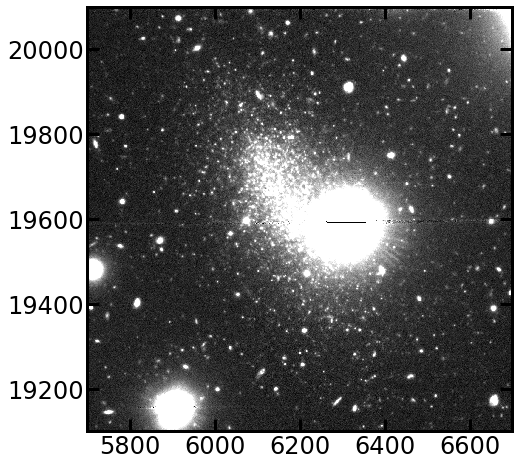

In [71]:
# Display the original image:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(my_calexp14.getMaskedImage()[5700:6700,19100:20100])

<Figure size 1008x504 with 0 Axes>

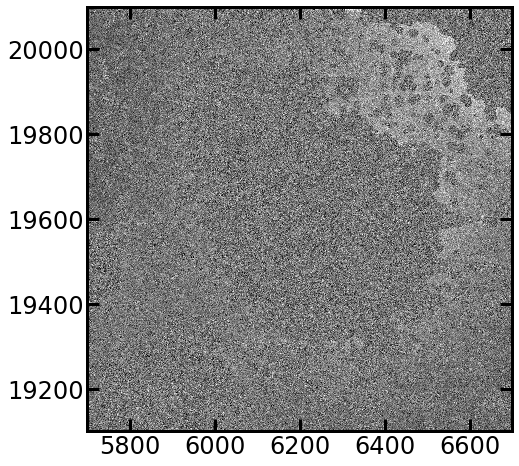

In [76]:
# Display the image with the source footprints replaced by noise:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('linear', 'zscale')
afw_display.mtv(calexp14.getMaskedImage()[5700:6700,19100:20100])

The fact that they subtracted off nicely confirms that the sources in KKR 25 were detected. Now the question is whether one can get measurements for those objects.

Text(0, 0.5, 'detected objects (arcmin$^{-2}$)')

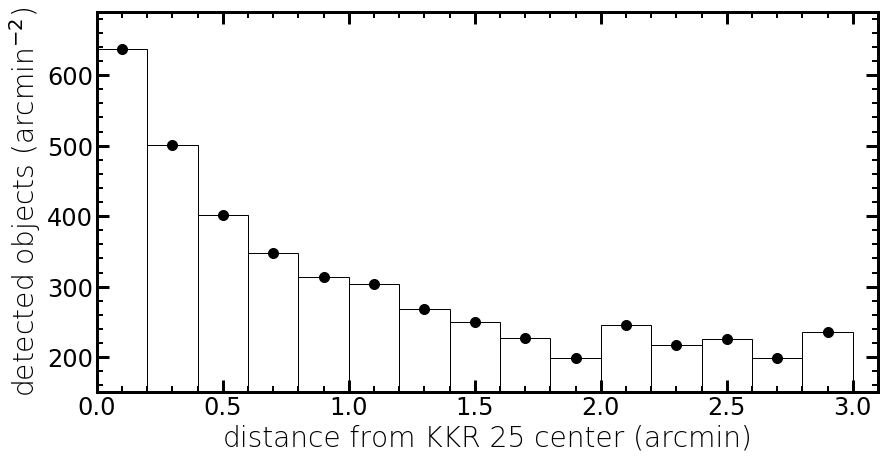

In [117]:
binwidth_arcmin = 0.2
radial_bins = np.arange(0, 3.1, binwidth_arcmin)
area_inside = np.pi*(radial_bins**2)
area_bin = 0.0*area_inside
for i in range(len(area_bin)-1):
    area_bin[i] = area_inside[i+1] - area_inside[i]
num_per_bin = np.histogram(sep_kkr25.arcmin, bins=radial_bins)
densities = num_per_bin[0]/area_bin[:-1]

plt.plot(num_per_bin[1][:-1]+binwidth_arcmin/2, densities, 'k.', ms=20)
plt.bar(num_per_bin[1][:-1]+binwidth_arcmin/2, densities, width=binwidth_arcmin, fill=False)
plt.xlim(0,3.1)
plt.ylim(150,690)
plt.minorticks_on()
plt.xlabel('distance from KKR 25 center (arcmin)')
plt.ylabel(r'detected objects (arcmin$^{-2}$)')
#plt.hist(sep_kkr25.arcmin,bins=np.arange(0,3.1,0.1))

The profile is peaked at KKR 25, also confirming that it is detected by the Stack, but simply not well measured.

# More exploration

- Are there reasonable aperture mags in the catalogs?
- Look at the footprints of detections in some zoomed-in region(s).
- Can we re-run detection and measurement with a different background scale to recover the stars nearer the center?
- ...or with the deblender assuming everything is a star?
- Check out the mask plane?
- How about masking the detected objects, smoothing, then subtracting off a simple Sersic model galaxy. Then when we add the sources back in it should be easier to measure them.

In [42]:
def cutoutCatalog_ApMags(raDec, size_arcmin, filter):
    '''
    Function to extract an catalog cutout, including aperture magnitudes.
    Inputs:
      raDec: an afwGeom.SpherePoint object with desired RA, Dec center 
      size_arcmin: desired image size (in arcminutes)
      filter: desired filter of extracted image (string)
    '''
# Start with a center position and make a bbox centered there, and expand it to include data from neighboring patches:
    skyMap =  butler.get("deepCoadd_skyMap", immediate=True, tract=tract, patch=patch, filter=filter)
    tmp_calexp = butler.get("deepCoadd_calexp", immediate=True, tract=tract, patch=patch, filter=filter)
    expWcs = tmp_calexp.getWcs()

    size_pixels = arcmin2pix(size_arcmin)
    cutoutSize = geom.ExtentI(size_pixels, size_pixels) # size of cutout in pixels
    xy = geom.Point2I(expWcs.skyToPixel(raDec)) # central XY coordinate of our star's RA, Dec position
    
# Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)
    bbox = geom.Box2D(bbox)

    tractInfo = skyMap.findTract(raDec)
    skyCorners = [expWcs.pixelToSky(pixPos) for pixPos in bbox.getCorners()]
    patchList = tractInfo.findPatchList(skyCorners)
    print('Npatches: ',len(patchList))

    nPatchesFound = 0
    for patchInfo in patchList:
        patchArgDict = dict(
                            datasetType="deepCoadd_forced_src",
                            tract=tractInfo.getId(),
                            patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                            filter = filter,
                            flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                            )
        print("Reading patch %s" % patchArgDict)
        src = butler.get(**patchArgDict)
        nPatchesFound += 1

        patchArgDict_ref = dict(
                                datasetType="deepCoadd_ref",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading ref cat for patch %s" % patchArgDict_ref)
        refcat = butler.get(**patchArgDict_ref)

        patchArgDict_calib = dict(
                                datasetType="deepCoadd_calexp_photoCalib",
                                tract=tractInfo.getId(),
                                patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
                                filter = filter,
                                flags=afwTable.SOURCE_IO_NO_FOOTPRINTS
                                )
        print("Reading calib for patch %s" % patchArgDict_calib)
        calib = butler.get(**patchArgDict_calib)
#        calib.setThrowOnNegativeFlux(False)
        psfmags = calib.instFluxToMagnitude(src, 'base_PsfFlux')
        psfmags_un = calib.instFluxToMagnitude(src, 'undeblended_base_PsfFlux')
        modelmags = calib.instFluxToMagnitude(src, 'modelfit_CModel')
        apmags_3_0 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_3_0')
        apmags_3_0_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_3_0')
        apmags_4_5 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_4_5')
        apmags_4_5_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_4_5')
        apmags_6_0 = calib.instFluxToMagnitude(src, 'base_CircularApertureFlux_6_0')
        apmags_6_0_un = calib.instFluxToMagnitude(src, 'undeblended_base_CircularApertureFlux_6_0')
        
#        psfmags = calib.instFluxToMagnitude(src.getPsfInstFlux())
#        modelmags = calib.instFluxToMagnitude(src.getModelInstFlux())
        
        # Use astropy 'hstack' to glom the mags onto the src catalog
        #src_all = src #.asAstropy()
        #src_all.extend(psfmags)
        #src_all['psfmag'] = psfmags
        #src_all['modelmag'] = modelmags
        #hstack([src.asAstropy(), Table(psfmags)])
        mags = Table()
        mags['psfmag'] = psfmags
        mags['psfmag_un'] = psfmags_un
        mags['modelmag'] = modelmags
        mags['apmag_3_0'] = apmags_3_0
        mags['apmag_3_0_un'] = apmags_3_0_un
        mags['apmag_4_5'] = apmags_4_5
        mags['apmag_4_5_un'] = apmags_4_5_un
        mags['apmag_6_0'] = apmags_6_0
        mags['apmag_6_0_un'] = apmags_6_0_un


        if nPatchesFound == 1:
            print('patch: 1')
            tmp_src = src
            tmp_ref = refcat
            tmp_mags = mags
            tmp_calib = calib
        else:
            print('patch: ',nPatchesFound)
            tmp_src.extend(src)
            tmp_ref.extend(refcat)
            tmp_mags = vstack([tmp_mags,mags])
            
        print('length of tmp_src, tmp_ref, tmp_mags: ',len(tmp_src),len(tmp_ref), len(tmp_mags))


    print('Making deep copies')
    cat_final = tmp_src.copy(deep = True)
    ref_final = tmp_ref.copy(deep = True)


    if nPatchesFound == 0:
        raise RuntimeError("No patches found!")

    return cat_final, ref_final, tmp_mags

In [43]:
cat_g_ap, refcat_g_ap, mags_g_ap = cutoutCatalog_ApMags(raDec, size_arcmin, 'HSC-G')
cat_i_ap, refcat_i_ap, mags_i_ap = cutoutCatalog_ApMags(raDec, size_arcmin, 'HSC-I')

Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,4', 'filter': 'HSC-G', 'flags': 1}
patch: 1
length of tmp_src, tmp_ref, tmp_mags:  30285 30285 30285
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading ref cat for patch {'datasetType': 'deepCoadd_ref', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
Reading calib for patch {'datasetType': 'deepCoadd_calexp_photoCalib', 'tract': 17130, 'patch': '1,5', 'filter': 'HSC-G', 'flags': 1}
patch:  2
length of tmp_src, tmp_ref, tmp_mags:  61007 61007 61007
Making deep copies
Npatches:  2
Reading patch {'datasetType': 'deepCoadd_forced_src', 'tract': 17130, 'patch

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in subtract


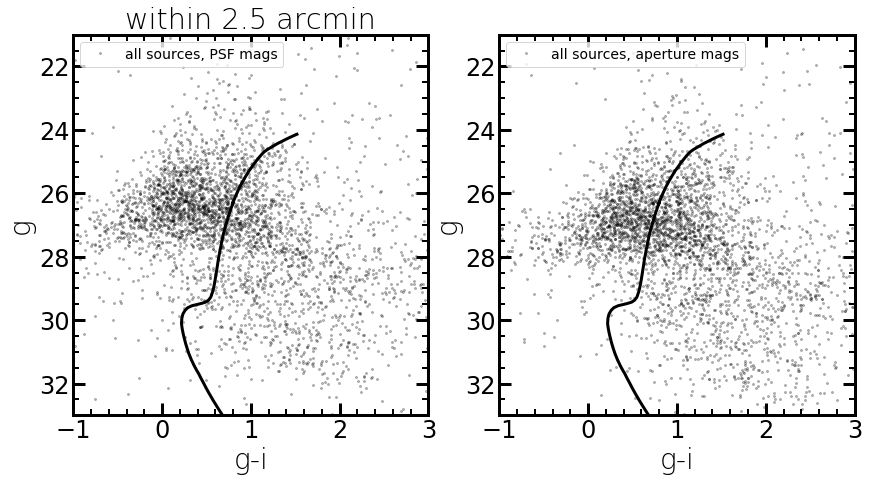

In [50]:
plt.rcParams.update({'figure.figsize' : (14, 7)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.subplot(121)
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources, aperture mag')
#plt.plot(mags_g_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g_ap['psfmag_un'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1, label='all sources, aperture mag')
#plt.plot(mags_g_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g_ap['apmag_3_0_un'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75, label='point sources')
plt.plot(mags_g_ap['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['psfmag'][is_primary & deblended & sel_cen][:,0],\
         mags_g_ap['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=2, alpha=0.25, label='all sources, PSF mags')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.legend()
plt.xlim(-1,3)
plt.ylim(33,21)
plt.title('within 2.5 arcmin')
plt.minorticks_on()

plt.subplot(122)
plt.plot(mags_g_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0]-mags_i_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0],\
         mags_g_ap['apmag_3_0'][is_primary & deblended & sel_cen][:,0], 'ko', ms=2, alpha=0.25, label='all sources, aperture mags')
#plt.scatter(mags_g_ap['psfmag_un'][is_primary & sel_cen][:,0]-mags_i_ap['psfmag_un'][is_primary & sel_cen][:,0],\
#            mags_g_ap['psfmag_un'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
#plt.scatter(mags_g_ap['apmag_3_0_un'][is_primary & sel_cen][:,0]-mags_i_ap['apmag_3_0_un'][is_primary & sel_cen][:,0],\
#            mags_g_ap['apmag_3_0_un'][is_primary & sel_cen][:,0], c=sep_kkr25[is_primary & sel_cen].arcmin, cmap='Spectral_r', s=5)
#plt.plot(mags_g['psfmag'][is_primary & deblended & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & sel_cen][:,0], 'ko', ms=5, alpha=0.1)
#plt.plot(mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0]-mags_i['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0],\
#         mags_g['psfmag'][is_primary & deblended & starsel_i & sel_cen][:,0], 'ro', ms=5, alpha=0.75)

#plt.plot(mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen]-mags_i['psfmag'][is_primary & deblended & ptsource & sel_cen], mags_g['psfmag'][is_primary & deblended & ptsource & sel_cen], 'ro', ms=5, alpha=0.3)
#plt.plot(mags_g['psfmag'][is_primary & ~ptsource & sel_cen]-mags_i['psfmag'][is_primary & ~ptsource & sel_cen], mags_g['psfmag'][is_primary & ~ptsource & sel_cen], 'bo', ms=3, alpha=0.3)
#plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, df_hsc[notstar_selection_kkr25].psf_mag_g, 'bo', fillstyle='none', ms=2, alpha=0.3)
#plt.scatter(df_hsc[selection_kkr25].psf_mag_g-df_hsc[selection_kkr25].psf_mag_i, df_hsc[selection_kkr25].psf_mag_g,\
#            c=df_hsc[selection_kkr25].psf_mag_i-df_hsc[selection_kkr25].cm_mag_i, cmap='Spectral_r')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k', label='__no label__')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(33,21)
plt.legend()
#plt.colorbar(label='dist from KKR 25 (arcmin)')
plt.minorticks_on()
#plt.show()

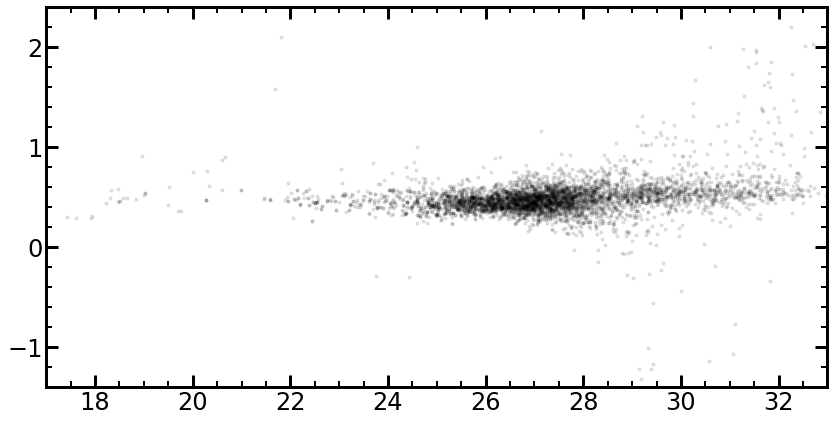

In [78]:
plt.figure()
plt.plot(mags_g_ap['apmag_3_0'][sel_cen][:,0], mags_g_ap['apmag_3_0'][sel_cen][:,0]-mags_g_ap['psfmag'][sel_cen][:,0], 'k.', alpha=0.1)
plt.ylim(-1.4,2.4)
plt.xlim(17,33)
plt.minorticks_on()

In [107]:
my_src14.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['D'](name="base_SdssCentroid_x", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=40, nElements=1)),
    (Field['D'](name="base_SdssCentroid_y", doc="centroid from Sdss Centroid algorithm", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['F'](name="base_SdssCentroid_xSigma", doc="1-sigma uncertainty on x position", units="pixel"), Key<F>(offset=56, nElements=1)),
    (Field['F'](name="base_SdssCentroid_ySigma", doc="1-sigma uncert

Next: concatenate the surrounding patches' catalogs, then move on to CMDs, density maps, etc.

In [110]:
%%time
# We must select object catalogs individually from the butler, then concatenate them.

#coadd_forced_src_array_g = []
#coadd_forced_src_array_r = []
#coadd_forced_src_array_i = []
coadd_forced_src_array = []

for ii in np.nonzero(selection_patch)[0]:
    tract, patch = df_tract_patch['tract'][ii], df_tract_patch['patch'][ii] 
    print('Tract, patch: ',tract, patch)
    dataid_g = {'filter':'HSC-G', 'tract':tract, 'patch':patch}
    dataid_r = {'filter':'HSC-R', 'tract':tract, 'patch':patch}
    dataid_i = {'filter':'HSC-I', 'tract':tract, 'patch':patch}
    coadd_forced_src_g = butler.get('deepCoadd_forced_src', dataId=dataid_g, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_g = butler.get('deepCoadd_ref', dataId=dataid_g, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_g = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_g)
    coadd_forced_src_r = butler.get('deepCoadd_forced_src', dataId=dataid_r, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_r = butler.get('deepCoadd_ref', dataId=dataid_r, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_r = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_r)
    coadd_forced_src_i = butler.get('deepCoadd_forced_src', dataId=dataid_i, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_ref_i = butler.get('deepCoadd_ref', dataId=dataid_i, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
    coadd_calib_i = butler.get('deepCoadd_calexp_photoCalib', dataId=dataid_i)
    
    selection_catalog = coadd_ref_i['detect_isPrimary'] \
        & ~coadd_forced_src_i['base_SdssCentroid_flag'] \
        & ~coadd_forced_src_i['base_PixelFlags_flag_interpolated'] \
        & ~coadd_forced_src_i['base_PixelFlags_flag_saturated'] \
        & ~coadd_forced_src_i['base_PsfFlux_flag'] \
        & ~coadd_forced_src_i['modelfit_CModel_flag']
    
#    coadd_calib_g.setThrowOnNegativeFlux(False)
    psf_mag_g = coadd_calib_g.instFluxToMagnitude(coadd_forced_src_g, 'base_PsfFlux')
    cm_mag_g = coadd_calib_g.instFluxToMagnitude(coadd_forced_src_g, 'modelfit_CModel')
#    coadd_calib_r.setThrowOnNegativeFlux(False)
    psf_mag_r = coadd_calib_r.instFluxToMagnitude(coadd_forced_src_r, 'base_PsfFlux')
    cm_mag_r = coadd_calib_r.instFluxToMagnitude(coadd_forced_src_r, 'modelfit_CModel')
#    coadd_calib_i.setThrowOnNegativeFlux(False)
    psf_mag_i = coadd_calib_i.instFluxToMagnitude(coadd_forced_src_i, 'base_PsfFlux')
    cm_mag_i = coadd_calib_i.instFluxToMagnitude(coadd_forced_src_i, 'modelfit_CModel')
    
#    data = {'ra': np.degrees(coadd_forced_src['coord_ra'][selection_catalog]),
#            'dec': np.degrees(coadd_forced_src['coord_dec'][selection_catalog]),
    data = {'ra': np.degrees(coadd_forced_src_i['coord_ra'][selection_catalog]),
            'dec': np.degrees(coadd_forced_src_i['coord_dec'][selection_catalog]),
            'psf_mag_g': psf_mag_g[selection_catalog][:,0],
            'cm_mag_g': cm_mag_g[selection_catalog][:,0],
            'psf_mag_r': psf_mag_r[selection_catalog][:,0],
            'cm_mag_r': cm_mag_r[selection_catalog][:,0],
            'psf_mag_i': psf_mag_i[selection_catalog][:,0],
            'cm_mag_i': cm_mag_i[selection_catalog][:,0]}
#            'psf_mag': psf_mag[selection_catalog],
#            'cm_mag': cm_mag[selection_catalog]}
    coadd_forced_src_array.append(pd.DataFrame(data=data))

dir(coadd_forced_src_i)
df_hsc = pd.concat(coadd_forced_src_array)

Tract, patch:  17130 0,4
Tract, patch:  17130 1,5
Tract, patch:  17130 0,5
Tract, patch:  17130 2,4
Tract, patch:  17130 1,4
Tract, patch:  17130 2,5
Tract, patch:  17131 8,4
Tract, patch:  17131 8,5
CPU times: user 15.3 s, sys: 3.01 s, total: 18.3 s
Wall time: 21.3 s


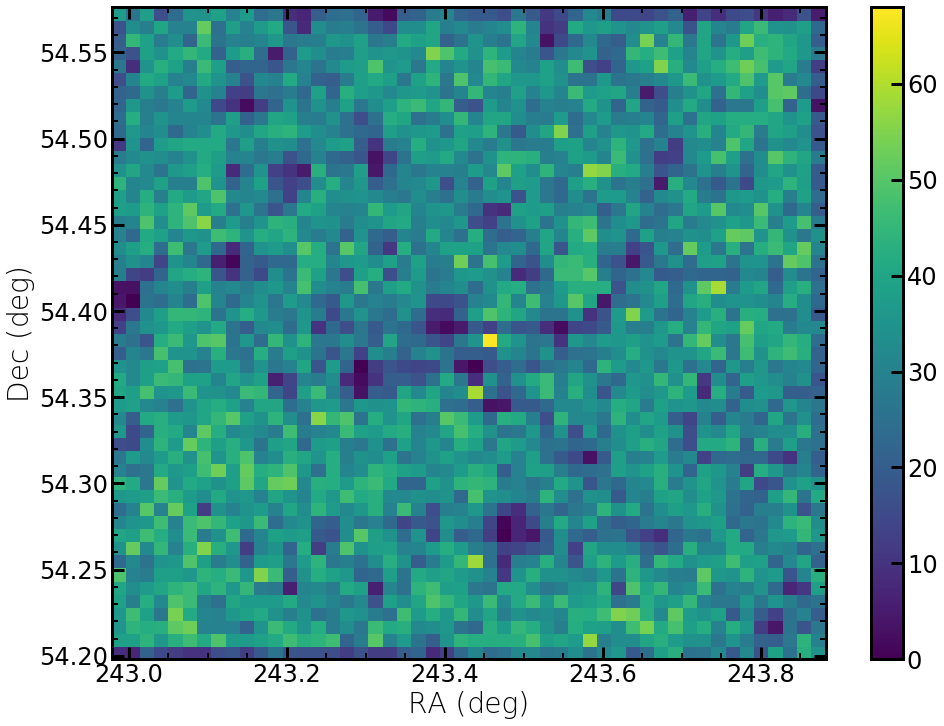

In [111]:
plt.rcParams.update({'figure.figsize' : (16, 12)})

plt.figure()
#plt.scatter(df_hsc['ra'], df_hsc['dec'], c='red', marker='.', s=10, alpha=0.1)
plt.hist2d(df_hsc['ra'], df_hsc['dec'], bins=50)
plt.colorbar()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

In [112]:
#ok = df_hsc['psf_mag_g'].notna() & df_hsc['psf_mag_r'].notna() & df_hsc['psf_mag_i'].notna()
#df_hsc.dropna(thresh=1,inplace=True)
df_hsc.dropna(subset=['psf_mag_g', 'psf_mag_r', 'psf_mag_i'], inplace=True)

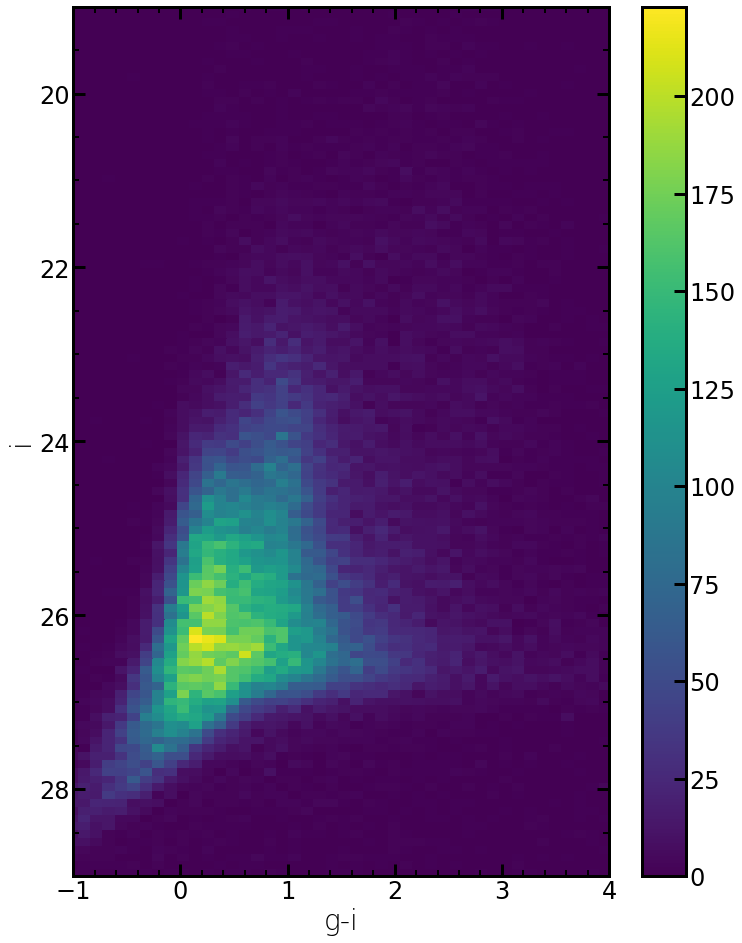

In [115]:
plt.rcParams.update({'figure.figsize' : (12, 16)})

plt.figure()

#plt.scatter(df_hsc['psf_mag_g']-df_hsc['psf_mag_i'], df_hsc['psf_mag_i'], c='red', marker='.', s=10, alpha=0.1)
plt.hist2d(df_hsc.psf_mag_g-df_hsc.psf_mag_i, df_hsc.psf_mag_i, bins=300)
#plt.hist2d(df_hsc[ok].psf_mag_g-df_hsc[ok].psf_mag_i, df_hsc[ok].psf_mag_i, bins=200)
plt.xlabel('g-i')
plt.ylabel('i')
plt.xlim(-1,4)
plt.ylim(29,19)
plt.colorbar()
plt.minorticks_on()
plt.show()

Text(0, 0.5, '$i_{\\rm PSF} - i_{\\rm cmodel}$')

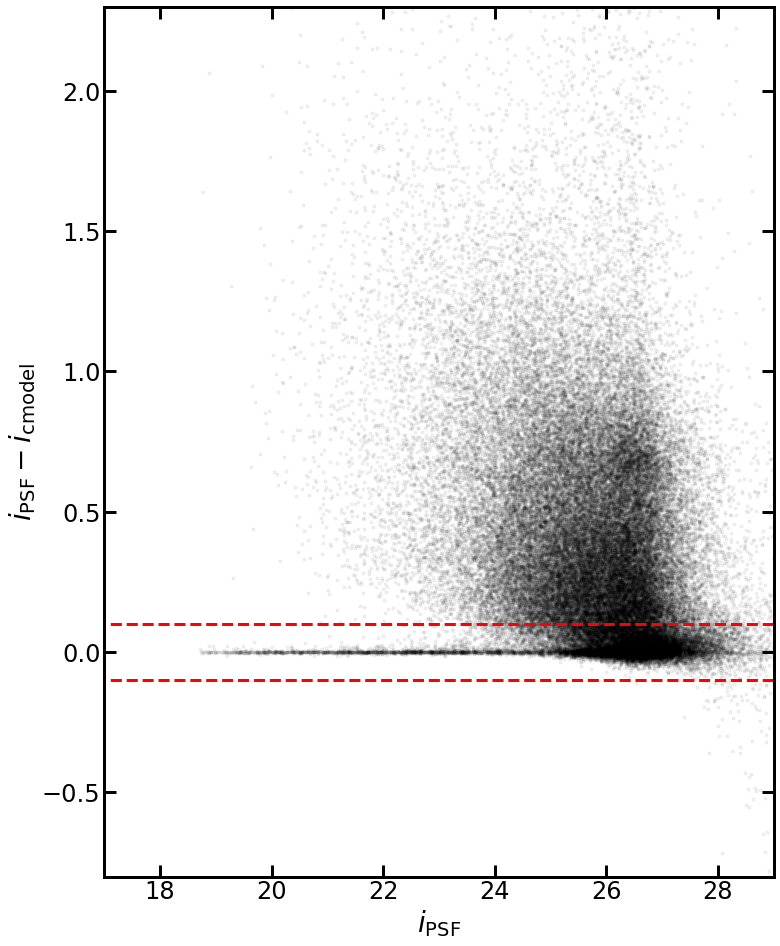

In [116]:
plt.figure()
plt.plot(df_hsc.psf_mag_i,df_hsc.psf_mag_i-df_hsc.cm_mag_i,'k.',alpha=0.05)
stargx_thresh = 0.1
plt.plot([0,30],[stargx_thresh,stargx_thresh],color='red',alpha=1.0,linestyle='--')
plt.plot([0,30],[-1.0*stargx_thresh,-1.0*stargx_thresh],color='red',alpha=1.0,linestyle='--')
plt.xlim(17,29)
plt.ylim(-0.8,2.3)
plt.xlabel(r'$i_{\rm PSF}$')
plt.ylabel(r'$i_{\rm PSF} - i_{\rm cmodel}$')

In [117]:
# Create "SkyCoord" objects for the central coordinate of KKR25 (or CetusIII, VirgoI?), and the patch centers of HSC:
kkr25_cen = SkyCoord(243.448333*u.degree, 54.37111*u.degree, frame='icrs')
#virgoI_cen = SkyCoord(180.04*u.degree, 0.68*u.degree, frame='icrs') # VirgoI
#kkr25_cen = virgoI_cen
hsc_coord = SkyCoord(df_hsc['ra'].values*u.degree, df_hsc['dec'].values*u.degree, frame='icrs')

# Calculate the separation (in degrees) of each HSC patch from KKR25:
sep_kkr25 = hsc_coord.separation(kkr25_cen)

# difference in mags (PSF - cmodel)
magdiff_i = df_hsc.psf_mag_i-df_hsc.cm_mag_i
starsel_i = (np.abs(magdiff_i) < stargx_thresh) & (df_hsc.psf_mag_g < 28) & (df_hsc.psf_mag_r < 28) & (df_hsc.psf_mag_i < 28)
rgbstarsel_i = (np.abs(magdiff_i) < stargx_thresh) & (df_hsc.psf_mag_g < 28) & (df_hsc.psf_mag_r < 28) & (df_hsc.psf_mag_i < 28) &\
               (df_hsc.psf_mag_g-df_hsc.psf_mag_i < 1.5) & (df_hsc.psf_mag_g-df_hsc.psf_mag_i > 0.5)             

# Pick patches within 'size_select' deg of KKR25:
size_select_kkr25 = 2.0/60.0 # in degrees
star_selection_kkr25 = (sep_kkr25.degree < size_select_kkr25) & starsel_i
notstar_selection_kkr25 = (sep_kkr25.degree < size_select_kkr25) & ~starsel_i
#print('Number of patches selected: ',np.sum(selection_patch))

In [79]:
# ! git clone https://github.com/asteca/ezpadova-2.git

In [80]:
## ! cp ezpadova-2/in_params_default.dat in_params.dat
#! python ezpadova-2/CMD.py

In [118]:
! ls isochrones/parsec12_panstarrs1

0_000100.dat  0_000500.dat  0_001520.dat


In [119]:
from astropy.io import ascii

iso = ascii.read('isochrones/parsec12_panstarrs1/0_000500.dat',header_start = 13)

dist = 1.7e6 # 1.91e6 # in pc
ebv = 0.008 # (E(B-V) = 0.008 according to Makarov+2012) -- look this up using the central coord?
dmod = 5.0*np.log10(dist) - 5.0 

# Raw PS1-band isochrone magnitudes
g_iso_ps1 = iso['gP1']
r_iso_ps1 = iso['rP1']
i_iso_ps1 = iso['iP1']
z_iso_ps1 = iso['zP1']

# Calculate colors needed to transform to HSC system
gr_iso_ps1 = g_iso_ps1 - r_iso_ps1
ri_iso_ps1 = r_iso_ps1 - i_iso_ps1
iz_iso_ps1 = i_iso_ps1 - z_iso_ps1

# PS1/HSC transformations from https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/#color-terms
# Resulting mags are in the HSC filter system:
g_iso_hsc = g_iso_ps1 + 0.00730066 + 0.06508481*gr_iso_ps1 - 0.01510570*(gr_iso_ps1**2)
r_iso_hsc = r_iso_ps1 + 0.00279757 + 0.02093734*ri_iso_ps1 - 0.01877566*(ri_iso_ps1**2)
i_iso_hsc = i_iso_ps1 + 0.00166891 - 0.13944659*iz_iso_ps1 - 0.03034094*(iz_iso_ps1**2)

# Extinction coefficients from Schlafly+2011:
A_g = 3.172 * ebv
A_r = 2.271 * ebv
A_i = 1.682 * ebv

g_iso = g_iso_hsc + dmod + A_g
r_iso = r_iso_hsc + dmod + A_r
i_iso = i_iso_hsc + dmod + A_i 

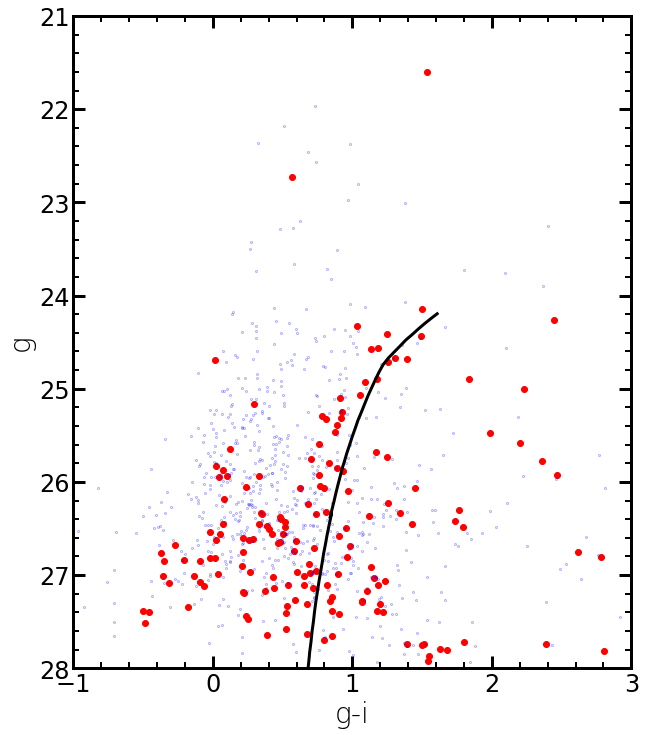

In [120]:
plt.rcParams.update({'figure.figsize' : (10, 12)})

plt.figure()

okstage = (iso['stage'] <= 3)

plt.plot(df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_i, df_hsc[star_selection_kkr25].psf_mag_g, 'ro', ms=6)
plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, df_hsc[notstar_selection_kkr25].psf_mag_g, 'bo', fillstyle='none', ms=2, alpha=0.3)
#plt.scatter(df_hsc[selection_kkr25].psf_mag_g-df_hsc[selection_kkr25].psf_mag_i, df_hsc[selection_kkr25].psf_mag_g,\
#            c=df_hsc[selection_kkr25].psf_mag_i-df_hsc[selection_kkr25].cm_mag_i, cmap='Spectral_r')
plt.plot(g_iso[okstage]-i_iso[okstage], g_iso[okstage], 'k')#s', ms=1)
plt.xlabel('g-i')
plt.ylabel('g')
plt.xlim(-1,3)
plt.ylim(28,21)
#plt.colorbar()
plt.minorticks_on()
plt.show()

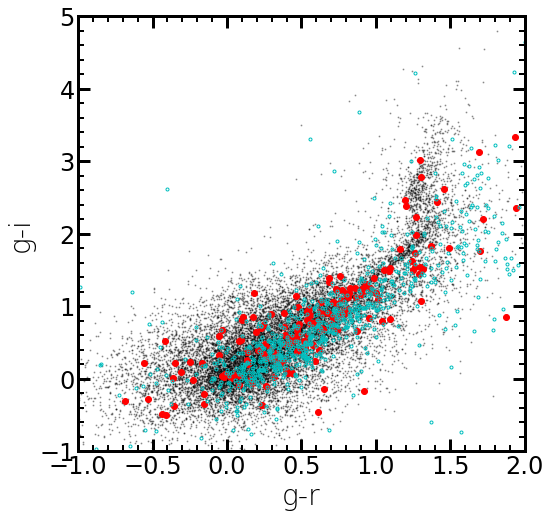

In [121]:
plt.rcParams.update({'figure.figsize' : (8, 8)})

plt.figure()

plt.plot(df_hsc[starsel_i].psf_mag_g-df_hsc[starsel_i].psf_mag_r, df_hsc[starsel_i].psf_mag_g-df_hsc[starsel_i].psf_mag_i, 'k.', ms=2, alpha=0.3)
#plt.plot(df_hsc[~starsel_i].psf_mag_g-df_hsc[~starsel_i].psf_mag_r, df_hsc[~starsel_i].psf_mag_g-df_hsc[~starsel_i].psf_mag_i, 'c.', ms=2, alpha=0.3)
plt.plot(df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_r, df_hsc[star_selection_kkr25].psf_mag_g-df_hsc[star_selection_kkr25].psf_mag_i, 'ro', ms=6)
plt.plot(df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_r, df_hsc[notstar_selection_kkr25].psf_mag_g-df_hsc[notstar_selection_kkr25].psf_mag_i, 'co', fillstyle='none', ms=3)
plt.xlabel('g-r')
plt.ylabel('g-i')
plt.xlim(-1,2)
plt.ylim(-1,5)
#plt.colorbar()
plt.minorticks_on()
plt.show()

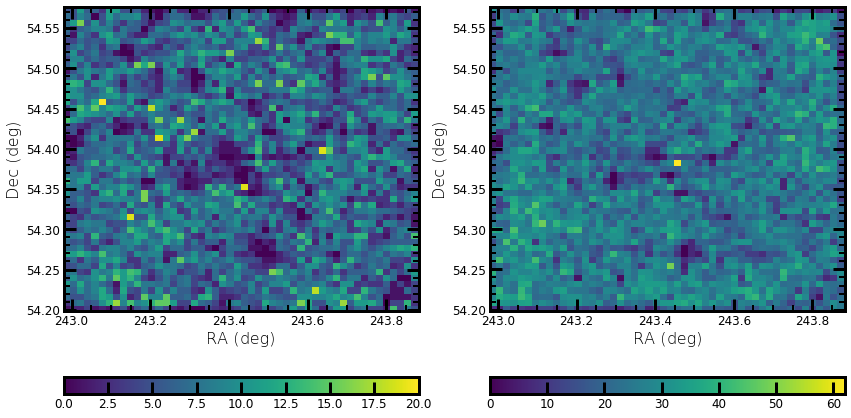

In [122]:
plt.rcParams.update({'figure.figsize' : (14, 8)})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'font.size': 12})

plt.subplot(121)
#plt.scatter(df_hsc['ra'], df_hsc['dec'], c='red', marker='.', s=10, alpha=0.1)
#plt.hexbin(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], gridsize=50)
plt.hist2d(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], bins=50)
plt.colorbar(orientation="horizontal")
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.subplot(122)
#plt.hexbin(df_hsc[~starsel_i]['ra'], df_hsc[~starsel_i]['dec'], gridsize=50)
plt.hist2d(df_hsc[~starsel_i]['ra'], df_hsc[~starsel_i]['dec'], bins=50)
plt.colorbar(orientation="horizontal")
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.minorticks_on()
plt.show()

<a class=“anchor” id=“kernel”></a>
# The Dwarf Filter (borrowed from Datalab DwarfGalaxiesInSmash_20180530.ipynb)
Here we define the dwarf filter as a differential convolution of a two-dimensional image using two Gaussian kernels; this has the effect of convolution with a Mexican hat filter.  The default kernel shapes look for objects on the scale of a few arcmin.  The output includes a clipped array of the convolved spatial distribution, which we will use for peak detection.

In [70]:
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution .... ",)

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    print('dwarf_filter: mean = {:g}  sigma = {:g} sigmaRaw = {:g}'.format(mean, sigma, sigmaRaw))

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [71]:
%%time
from astropy import convolution
small_k, big_k = 1.0, 10.   # kernel sizes in arcmin
raw, extent, delta, clipped, dsigma = dwarf_filter(df_hsc[starsel_i]['ra'], df_hsc[starsel_i]['dec'], fwhm_small=small_k, fwhm_big=big_k)

Computing differential convolution .... 
dwarf_filter: mean = 5.08827  sigma = 7.44346 sigmaRaw = 8.00623
CPU times: user 13.1 ms, sys: 3 µs, total: 13.1 ms
Wall time: 12.5 ms


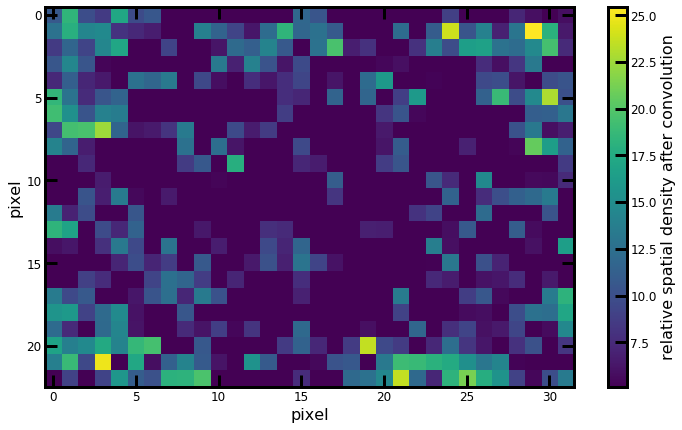

In [72]:
plt.rcParams.update({'figure.figsize' : (12, 7)})
#plt.subplots()
plt.figure()
plt.imshow(clipped)
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

Next steps:

- "Proper" star/galaxy separation
- Fix data flags selection
- Adapt Datalab convolution kernel, overdensity selection technique
- Density changes with diff star/gx choices
- Subselections based on CMD/CCD, and possibly isochrone filtering

## Section Title

Explain what we are going to do in this section.

In [ ]:
# If a particular line of python needs explaining, do it!
print("Hello World")

## Summary

Remind the user what they have done, and what they should now be able to do.

You could also point them to a related tutorial or reference source, to help them go further.